In [1]:
# Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.config import load_config_nb
from itertools import product, combinations
from pyvirtualdisplay import Display

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 3)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'

import yaml
from nocturne.envs.base_env import BaseEnv

### Settings

In [2]:
env_config = load_config_nb("env_config")
video_config = load_config_nb("video_config")

env_config.data_path = "../data_lp/"
env_config.subscriber.use_observations = False
env_config.subscriber.use_ego_state = False
env_config.subscriber.use_current_position = True # Use position, speed, ...
env_config.normalize_state = False

# Action space
env_config.accel_discretization = 1
env_config.steering_discretization = 3
env_config.accel_lower_bound = 0.0
env_config.accel_upper_bound = 0.0
env_config.steering_lower_bound = -0.5
env_config.steering_upper_bound = 0.5

In [3]:
# Make environment
env = BaseEnv(env_config)
env.reset()
veh_obj = env.controlled_vehicles[0]

print(f'Controlling veh: {veh_obj.id}')

Controlling veh: 32


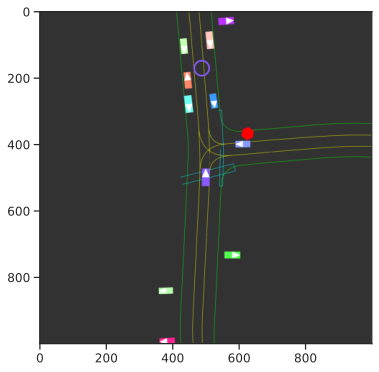

In [4]:
# Render
with Display(backend="xvfb") as disp:
    scene_img = env.scenario.getImage(
        img_width=1000,
        img_height=1000,
        padding=0,
        draw_target_positions=True,
        source=veh_obj,
        view_width=100,
        view_height=100,
        rotate_with_source=True,
    )

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(scene_img);

In [5]:
scene_img.shape

(1000, 1000, 4)

### Implementation

#### **Steps**
1. **Generate the set of possible action sequences** 

\begin{align*}
    \mathcal{A} &= \{ (a_{t=0}, a_{t=1}, ..., a_{t=T}), ... , (a_{t=0}, a_{t=1}, ..., a_{t=T}) \} \\
                &= \{ (0, 0, ..., 0), ... , (A, A, .., A) \}
\end{align*}

where we take the number of possible actions $A = 3$ and $T =8$ as the maximum sequence length (the number of steps).
    
2. **Generate the set of states by stepping the environment with every action sequence**

    - We step the environment with each action sequence and store the states and respective rewards

$$$$

3. **Remove duplicate states**

    - The combined set of action sequences will result in state redundancy, we remove all duplicate states 


___

_*_ Formulating this problem is NP-hard 

_*_ NOTE: We currently set the maximum sequence length $T$ to 8, because the time complexity for `itertools.product()` is O(m*n), where m and n are the sizes of the two lists -- (cartesian product, equivalent to a nested for-loop).

In [95]:
# Constants
NUM_REP_ACTION = 2 # How many times to repeat every action
AGENT_ID = veh_obj.id
VERBOSE = False
MAX_STEPS = 8

# Reset environment and get initial state
init_state = env.reset()[AGENT_ID]

print(f"Max actions: {MAX_STEPS}")

# Define number of states, reward, transition matrix, and discount factor
num_actions = env.action_space.n
num_states = num_actions ** MAX_STEPS
states = {}
reward = {}
transition = {}
gamma = 1.0

# Set initial state and reward
states[0] = init_state
reward[0] = 0

# Get all possible action sequences
#action_seqs = list(product(env.idx_to_actions, repeat=MAX_STEPS))
action_seqs = list(product(env.action_space, repeat=MAX_STEPS))

# Iterate through all action sequences
state_idx = 1
for action_seq_idx, action_seq in enumerate(action_seqs):

    # Print progress
    if VERBOSE:
        print(f"Action index: {action_seq_idx + 1} / {len(action_seqs)}")
        print(f"Action sequence: {action_seq}")
    else:
        print("\rAction index: {} / {}".format(action_seq_idx + 1, len(action_seqs)), end="")
    
    # Reset environment
    obs = env.reset()
    
    # Step through scene using action sequence
    for action_idx, action in enumerate(action_seq):
        
        # Reset reward for action
        total_reward = 0

        # Repeat action
        for _ in range(NUM_REP_ACTION):
            obs, rew, done, info = env.step({AGENT_ID: action})
            total_reward += rew[AGENT_ID]
            if done['__all__']:  # Stop if agent is done
                total_reward += 10 if info[AGENT_ID]['goal_achieved'] else -10
                if VERBOSE:
                    print("GOAL ACHIEVED!" if info[AGENT_ID]['goal_achieved'] else "Oh no, the car crashed!")
                break
        
        # Get next state
        next_state = obs[AGENT_ID]

        # Store state, reward, and transition
        states[state_idx] = next_state
        reward[state_idx] = total_reward
        transition[((state_idx - 1) if (action_idx != 0) else 0, action)] = state_idx

        # Increment state index
        state_idx += 1

        if done['__all__']:  # Stop if agent is done
            break
    if not done['__all__'] and VERBOSE:
        print("The car is not done driving...")
    
    if VERBOSE:
        print("\n")

if not VERBOSE:
    print("\n")

Max actions: 8
Action index: 6561 / 6561



In [96]:
len(states)

52489

In [97]:
# Remove duplicate states
states_df = pd.DataFrame(
    index = states.keys(),
    data = states.values(),
    columns = ["x", "y", "speed", "angle"],
)
states_full_df = pd.merge(
    left = states_df,
    right = states_df.drop_duplicates().reset_index(drop=True).reset_index().rename(columns={"index": "state_map"}),
    how = "left",
    on = ["x", "y", "speed", "angle"],
)
state_map = states_full_df["state_map"].to_dict()

# Remap states, rewards, and transitions
states = {state_map[state_idx]: state for state_idx, state in states.items()}
reward = {state_map[state_idx]: rew for state_idx, rew in reward.items()}
transition = {(state_map[state_idx], action): state_map[next_state_idx] for (state_idx, action), next_state_idx in transition.items()}

# Convert transition to 3D numpy array
transition_array = np.zeros((len(states), num_actions, len(states)))
for (state_idx, action), next_state_idx in transition.items():
    transition_array[state_idx, action, next_state_idx] = 1

# Display number of states
print(f"Number of states: {len(states)}")

Number of states: 694


In [98]:
from pyomo.environ import ConcreteModel, Var, minimize, SolverFactory

### Solve using linear programming

#### **Steps**

- We now have all the possible constraints and can formulate our LP

In [30]:
3 * 694

2082

In [90]:
# Step 0: Create an instance of the model
model = ConcreteModel()

# Step 1: Define index sets
states_set = list(range(len(states)))
actions_set = list(range(num_actions))

# Step 2: Define the decision 
model.v = Var(states_set, initialize=0)

# Step 3: Define Objective
@model.Objective(sense=minimize)
def objective(m):
    return sum([model.v[s] for s in states_set])

# Step 4: Constraints
@model.Constraint(states_set, actions_set)
def state_value_constraint(m, s, a):
    return model.v[s] >= reward[s] + gamma * sum([transition_array[s, a, s2] * model.v[s2] for s2 in states_set])

# Step 5: Solve
results = SolverFactory('glpk').solve(model)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 67.0990123521223
  Upper bound: 67.0990123521223
  Number of objectives: 1
  Number of constraints: 2082
  Number of variables: 694
  Number of nonzeros: 3426
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.0292510986328125
# ----------------------------------------------------------
#   Solution Information
# --------

In [23]:
# Display results
#model.display()

In [26]:
# Get LP solution values
values = np.array([val.value for val in model.v.values()])

# Find optimal path and actions
opt_states = [0]
opt_actions = []
for _ in range(15):
    next_values = np.multiply(transition_array[opt_states[-1], :, :], values)
    if (next_values == 0).all():
        break
    opt_next = next_values.max(axis=0).argmax()
    opt_action = transition_array[opt_states[-1], :, opt_next].argmax()
    opt_states.append(opt_next)
    opt_actions.append(opt_action)

# Display optimal path and actions
df = pd.DataFrame(
    index = opt_states,
    data = {
        "x": [states[state_idx][0] for state_idx in opt_states],
        "y": [states[state_idx][1] for state_idx in opt_states],
        "speed": [states[state_idx][2] for state_idx in opt_states],
        "angle": [states[state_idx][3] for state_idx in opt_states],
        "value": [values[state_idx] for state_idx in opt_states],
        "action": [*[opt_action for opt_action in opt_actions], None],
    },
)

In [27]:
df.to_csv("lp_benchmark.csv")

### Plot

In [7]:
# Load csv
df = pd.read_csv("lp_benchmark.csv")

# Make environment
env = BaseEnv(env_config)
env.reset()
veh_obj = env.controlled_vehicles[0]

In [8]:
df

,Unnamed: 0,x,y,speed,angle,value,action
0,0,9032.820312,-2718.313232,0.110296,0.0,0.155272,0.0
1,1,9032.825195,-2718.323242,0.110296,-0.5,0.155272,1.0
2,213,9032.832031,-2718.331787,0.110296,0.0,0.136043,1.0
3,215,9032.838867,-2718.340332,0.110296,0.0,0.116763,1.0
4,217,9032.845703,-2718.348877,0.110296,0.0,0.097431,1.0
5,219,9032.852539,-2718.357422,0.110296,0.0,0.078048,1.0
6,221,9032.859375,-2718.365967,0.110296,0.0,0.058613,1.0
7,223,9032.866211,-2718.374512,0.110296,0.0,0.039127,1.0
8,225,9032.873047,-2718.383057,0.110296,0.0,0.019589,NaN


In [9]:
# Render scene
with Display(backend="xvfb") as disp:
    scene_img = env.scenario.getImage(
        img_width=1200,
        img_height=1200,
        padding=0,
        draw_target_positions=True,
        source=veh_obj,
        view_width=100,
        view_height=100,
        rotate_with_source=True,
    )

    cone_img = env.scenario.getConeImage(
        source=veh_obj,
        view_dist=80,
        view_angle=np.pi,
        head_angle=0,
        img_width=2000,
        img_height=2000,
        padding=0.,
        draw_target_position=True,
    )

In [10]:
coords = np.concatenate((df['x'].values, df['y'].values))
df['x_norm'] = (df['x'] - coords.min()) / (coords.max() - coords.min()) * 1000
df['y_norm'] = (df['y'] - coords.min()) / (coords.max() - coords.min()) * 1000

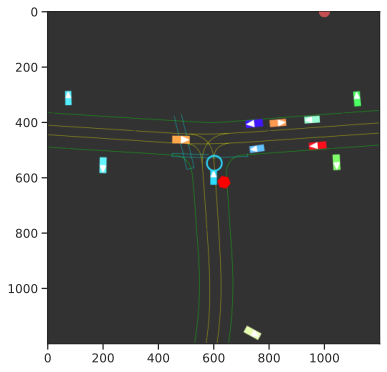

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(scene_img);
ax.scatter(df['x_norm'][0], df['y_norm'][0], c='r', s=100, zorder=10)

# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.imshow(cone_img);

In [12]:
df

,Unnamed: 0,x,y,speed,angle,value,action,x_norm,y_norm
0,0,9032.820312,-2718.313232,0.110296,0.0,0.155272,0.0,999.995512,0.005942
1,1,9032.825195,-2718.323242,0.110296,-0.5,0.155272,1.0,999.995928,0.005090
2,213,9032.832031,-2718.331787,0.110296,0.0,0.136043,1.0,999.996510,0.004363
3,215,9032.838867,-2718.340332,0.110296,0.0,0.116763,1.0,999.997091,0.003636
4,217,9032.845703,-2718.348877,0.110296,0.0,0.097431,1.0,999.997673,0.002909
5,219,9032.852539,-2718.357422,0.110296,0.0,0.078048,1.0,999.998255,0.002181
6,221,9032.859375,-2718.365967,0.110296,0.0,0.058613,1.0,999.998837,0.001454
7,223,9032.866211,-2718.374512,0.110296,0.0,0.039127,1.0,999.999418,0.000727
8,225,9032.873047,-2718.383057,0.110296,0.0,0.019589,NaN,1000.000000,0.000000


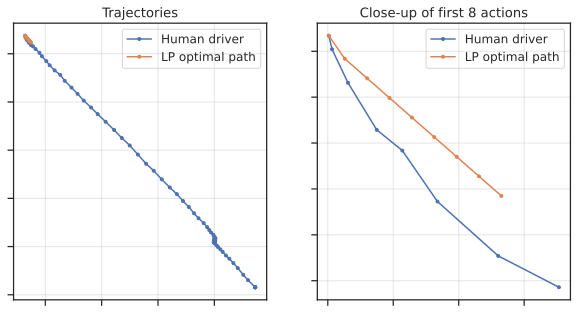

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(expert_coords_x, expert_coords_y, '.-', label='Human driver')
axs[0].plot(df['x'], df['y'], '.-', label='LP optimal path')

axs[1].plot(expert_coords_x[:8], expert_coords_y[:8], '.-', label='Human driver')
axs[1].plot(df['x'], df['y'], '.-', label='LP optimal path')

axs[1].legend(), axs[0].legend()
axs[0].set_xticklabels([]), axs[1].set_xticklabels([])
axs[0].set_yticklabels([]), axs[1].set_yticklabels([])
axs[0].grid(True, alpha=0.5), axs[1].grid(True, alpha=0.5),

axs[0].set_title(f'Trajectories')
axs[1].set_title(f'Close-up of first 8 actions');

In [13]:
=# Obtain human driver trajectory
expert_coords_x = []
expert_coords_y = []

# Make environment
env = BaseEnv(env_config)
env.reset()
veh_obj = env.controlled_vehicles[0]

veh_obj.expert_control = True

for t in range(80):
    expert_coords_x.append(veh_obj.position.x)
    expert_coords_y.append(veh_obj.position.y)
    env.step({})